In [43]:
import numpy as np
import pandas as pd
import os
from PIL import Image

import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d
import cv2

In [44]:
def load_gray_image(img_path) :
    img = Image.open(img_path).convert('L').resize((200, 200), resample=Image.LANCZOS)
    img.load()
    data = np.asarray(img, dtype="uint8")
    return data
  


def save_image(npdata, out_path) :
    img = Image.fromarray( np.asarray( np.clip(npdata,0,255), dtype="uint8"), "L")
    img.save(out_path)

# function that performs edge detection
def edge_detection(img):
  """
  img: input image (H,W)

  returns: 
  gmag: gradient magnitude image (H,W)
  ang: angle image (H,W)
  gmag_nms: gradient magnitude image after non-maximal suppression (H,W)
  """
  # your code here
  H, W = img.shape  
  nimg = img / 255
  gsimg = gaussian_filter(nimg, sigma=0.5)
  sobel_y = [[-1, -2, -1],
             [0, 0, 0],
             [1, 2, 1]]
  sobel_x = [[-1, 0, 1],
             [-2, 0, 2],
             [-1, 0, 1]]
  gy = convolve2d(gsimg, sobel_y)
  gx = convolve2d(gsimg, sobel_x)
  gmag = np.sqrt(gy ** 2 + gx ** 2)
  ang = np.arctan2(gy, gx)
  
  gmag_nms = np.zeros([H, W])

  for y in range(H):
    for x in range(W):
      temp_mag = gmag[y, x]
      # Initialize neighbors for comparison
      p1 = float('-inf')
      p2 = float('-inf')
      a = ang[y, x]
      # Get neighbors for each respective direction bin
      if abs(a) <= 22.5 or abs(a) >= 157.5:
        try: p1 = gmag[y-1, x]
        except: pass
        try: p2 = gmag[y+1, x]
        except: pass
      elif (a > 22.5 and a < 67.5) or (a < -112.5 and a > -157.5):
        try: p1 = gmag[y-1, x-1]
        except: pass
        try: p2 = gmag[y+1, x+1]
        except: pass
      elif (abs(a) > 67.5 and abs(a) < 112.5):
        try: p1 = gmag[y, x-1]
        except: pass
        try: p2 = gmag[y, x+1]
        except: pass
      elif (a < -22.5 and a > -67.5) or (a > 112.5 and a < 157.5):
        try: p1 = gmag[y-1, x+1]
        except: pass
        try: p2 = gmag[y+1, x-1]
        except: pass
      # If magnitude is less than directional neighbors, suppress to 0
      if temp_mag < p1 or temp_mag < p2:
        temp_mag = 0
      gmag_nms[y, x] = temp_mag

  return gmag, ang, gmag_nms

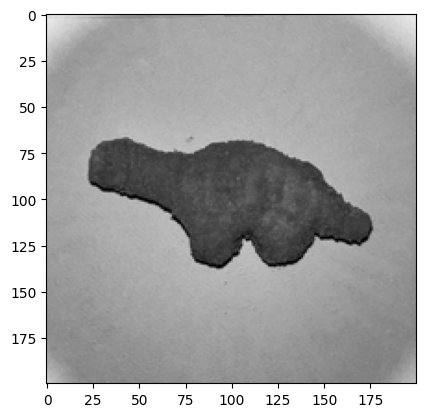

In [45]:
img_path = '../gli_images/IMG_E3919.JPG'
gray_img = load_gray_image(img_path)
plt.imshow(gray_img, cmap='gray', vmin=0, vmax=255)

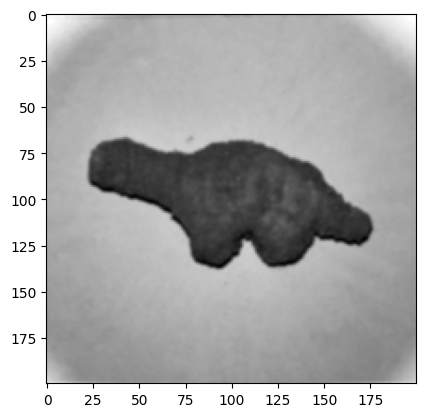

In [46]:
# Function for constructing gaussian lowpass filter in frequency domain
def gaussian_lpf_generator(var, P, Q):
  e_val = np.e
  
  freq_kernel = np.zeros((P, Q))
  for v in range(freq_kernel.shape[0]):
    for u in range(freq_kernel.shape[1]):
      # Distance from center
      d = np.sqrt(((u - P/2)**2) + ((v-Q/2)**2))
      
      freq_kernel[v, u] = e_val ** (-(d**2)/(2 * var))
  return freq_kernel

# function that applies gaussian low-pass filter in the frequency domain
def gaussian_lpf(img, var):
  """
  img: input image (H,W)
  var: variance for the gaussian lowpass filter 

  returns:
  out: output image after low-pass filter has been applied in the frequency domain
  """
  # your code here
  fft_img = np.fft.fftshift(np.fft.fft2(img))
  lpf = gaussian_lpf_generator(var, img.shape[0], img.shape[1])
  out = np.fft.ifft2(np.fft.ifftshift(np.multiply(fft_img, lpf)))

  return out.real

gauss_img = gaussian_lpf(gray_img, 42 ** 2)
plt.imshow(gauss_img, cmap='gray')

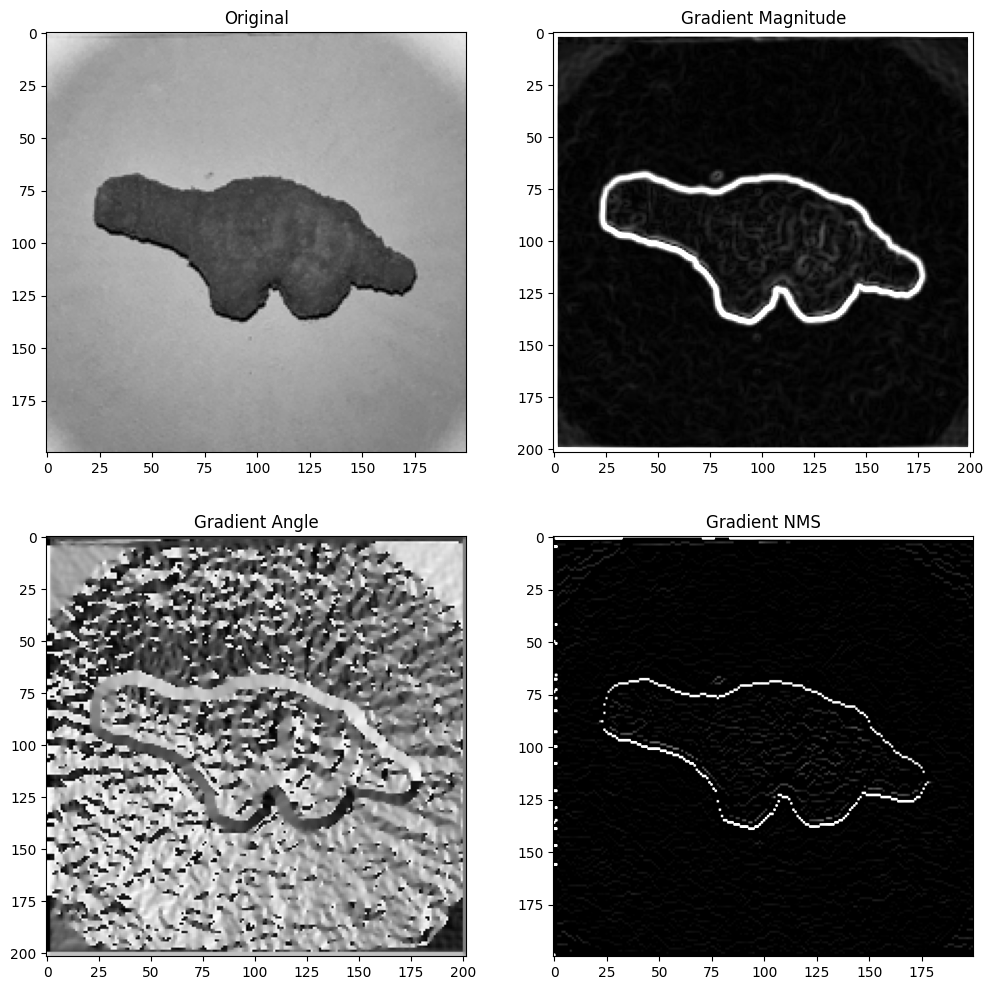

In [47]:
"""
Call the function edge_detection function with the cameraman image. 
Display the input image and all three output images from your edge_detection function.
"""


# your code here
gmag, ang, gmag_nms = edge_detection(gauss_img)

fig_3, ax_3 = plt.subplots(2, 2, figsize=(12, 12))

ax_3[0, 0].imshow(gray_img, cmap='gray', vmin=0, vmax=255)
ax_3[0, 0].set_title("Original")

ax_3[0, 1].imshow(gmag, cmap='gray', vmin=0, vmax=1)
ax_3[0, 1].set_title("Gradient Magnitude")

ax_3[1, 0].imshow(ang, cmap='gray')
ax_3[1, 0].set_title("Gradient Angle")

ax_3[1, 1].imshow(gmag_nms, cmap='gray', vmin=0, vmax=1)
ax_3[1, 1].set_title("Gradient NMS")

plt.show()
